# Trabajo Práctico N°2: Modelo de predicción de precios de propiedades 

## Desafío 2. Modelo para el calculo del precio aproximado en USD de las  propiedades

Grupo Nª2
Alumnos:
* Alberto Paparelli
* André Song
* Marianela Riz
* Gloria Caravajal
* Franco Emanuel Rodriguez

Objetivos:
● Seleccionar los datos a modelar. Justificar esa selección.
● Entrenar al menos tres modelos de regresión lineal distintos sobre estos datos.
● Evaluar la performance de los modelos y comparar ventajas y desventajas de cada
uno.
● Determinar la importancia de las features incluidas en la predicción. Interpretar.

## Modelos a desarrollar

**Para tener claridad se presenta una notebook para cada modelo.**

1- Modelo para apartamentos de Capital Federal

2- Modelo para apartamentos usados de Palermo

3- Modelo aplicado a apartamentos usados en Recoleta

4- Modelo regularizado (lasso y rich) para apartamentos de Capital Federal


# Importación de librerias

In [18]:
#importamos librerias para tratamiento de datos
import numpy as np
import pandas as pd
import re
import math as mat

#importamos librerias la visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
%matplotlib inline




## Cargue del Dataframe de Capital Federal

Hemos seleccionado este State_name porqué aunque con la limpieza se perdieron algunos datos, sigue teniendo una cantidad importante de datos.
Adicionalmente, estos datos ya traen consigo la información en los Place_name de los barrios de la Capital Federal, que puede ser una variable explicativa del precio del metro cuadrado de las propiedades.

In [19]:
filename = "../dataset/capital.csv"
data_original = pd.read_csv(filename, sep=',')
display(data_original.sample(n=2))
print(f"(Cantidad de Filas, Cantidad de columnas) -> {data_original.shape}")

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
14730,14730,14731,apartment,San Telmo,19603040,111100,45,38,2469,2924,8,1,0,1,0,1,1,Descripción General: Ubicado a metros del Cora...,Nuevo Edificio en San Telmo
7938,7938,7939,apartment,Caballito,23720913,134438,45,34,2988,3954,16,2,0,1,1,1,1,VENTA DEPARTAMENTO 2 AMBIENTES CABALLITOUnidad...,DEPARTAMENTO EN VENTA


(Cantidad de Filas, Cantidad de columnas) -> (16938, 19)


In [20]:
data=data_original[(data_original.property_type=="apartment")]
display(data.sample(2))
data.shape

,Unnamed: 0,numero,property_type,place_name,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo,description,title
1054,1054,1055,apartment,Villa Crespo,1623294,92000,40,36,2300,2556,3,1,18000,0,0,0,0,Venta de Departamento monoambiente en Villa Cr...,DEPARTAMENTO EN VENTA
2172,2172,2173,apartment,Barrio Norte,1588005,90000,25,25,3600,3600,1,1,0,0,0,1,0,"GRAN AMBIENTE, COCINA, BAÑO COMPLETOCfte lumin...",VENTA: MONOAMBIENTE APTO PROFESIONAL!!!!! en B...


(14222, 19)

Vamos a eliminar las columnas que no vamos a emplear para desarrollar los modelos: Description y Title

In [21]:
data.drop([data.columns[0],"numero","description","price_aprox_local_currency","price_per_m2" ,"title", "property_type"], axis=1,inplace=True)
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14222 entries, 0 to 16937
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   place_name             14222 non-null  object
 1   price_aprox_usd        14222 non-null  int64 
 2   surface_total_in_m2    14222 non-null  int64 
 3   surface_covered_in_m2  14222 non-null  int64 
 4   price_usd_per_m2       14222 non-null  int64 
 5   floor                  14222 non-null  int64 
 6   rooms                  14222 non-null  int64 
 7   expenses               14222 non-null  int64 
 8   piscina                14222 non-null  int64 
 9   Parrilla               14222 non-null  int64 
 10  Cochera                14222 non-null  int64 
 11  nuevo                  14222 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 1.4+ MB


c:\Users\usuario\anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Hacemos un último chequeo para que no tengamos nans en la columnas con las que vamos a trabajar

In [22]:
data.isna().sum()

place_name               0
price_aprox_usd          0
surface_total_in_m2      0
surface_covered_in_m2    0
price_usd_per_m2         0
floor                    0
rooms                    0
expenses                 0
piscina                  0
Parrilla                 0
Cochera                  0
nuevo                    0
dtype: int64

Creamos un grupo de variables númericas empleando. describe, tambien chequemos los valores minimos y máximos de las variables.

In [23]:
num=data.describe()
num

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
count,1.422200e+04,14222.000000,14222.000000,14222.000000,14222.000000,14222.000000,1.422200e+04,14222.000000,14222.000000,14222.00000,14222.000000
mean,3.097935e+05,76.197792,66.947687,4505.758543,2.727535,2.360990,2.277645e+04,0.296653,0.335255,0.38799,0.502602
std,5.003292e+05,61.726580,62.181870,6617.354554,2.433753,1.329184,1.186171e+06,0.456798,0.472096,0.48731,0.500011
min,5.500000e+03,10.000000,2.000000,71.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,1.060000e+05,40.000000,36.000000,2143.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
50%,1.572190e+05,55.000000,48.000000,2609.000000,2.000000,2.000000,0.000000e+00,0.000000,0.000000,0.00000,1.000000
75%,2.950000e+05,87.000000,75.000000,3362.000000,4.000000,3.000000,1.000000e+01,1.000000,1.000000,1.00000,1.000000
max,1.133952e+07,789.000000,3673.000000,206333.000000,27.000000,15.000000,1.000150e+08,1.000000,1.000000,1.00000,1.000000


Graficamos box plots para revisar si tenemos outliers dentro de las variables que puedan afectar la predicción

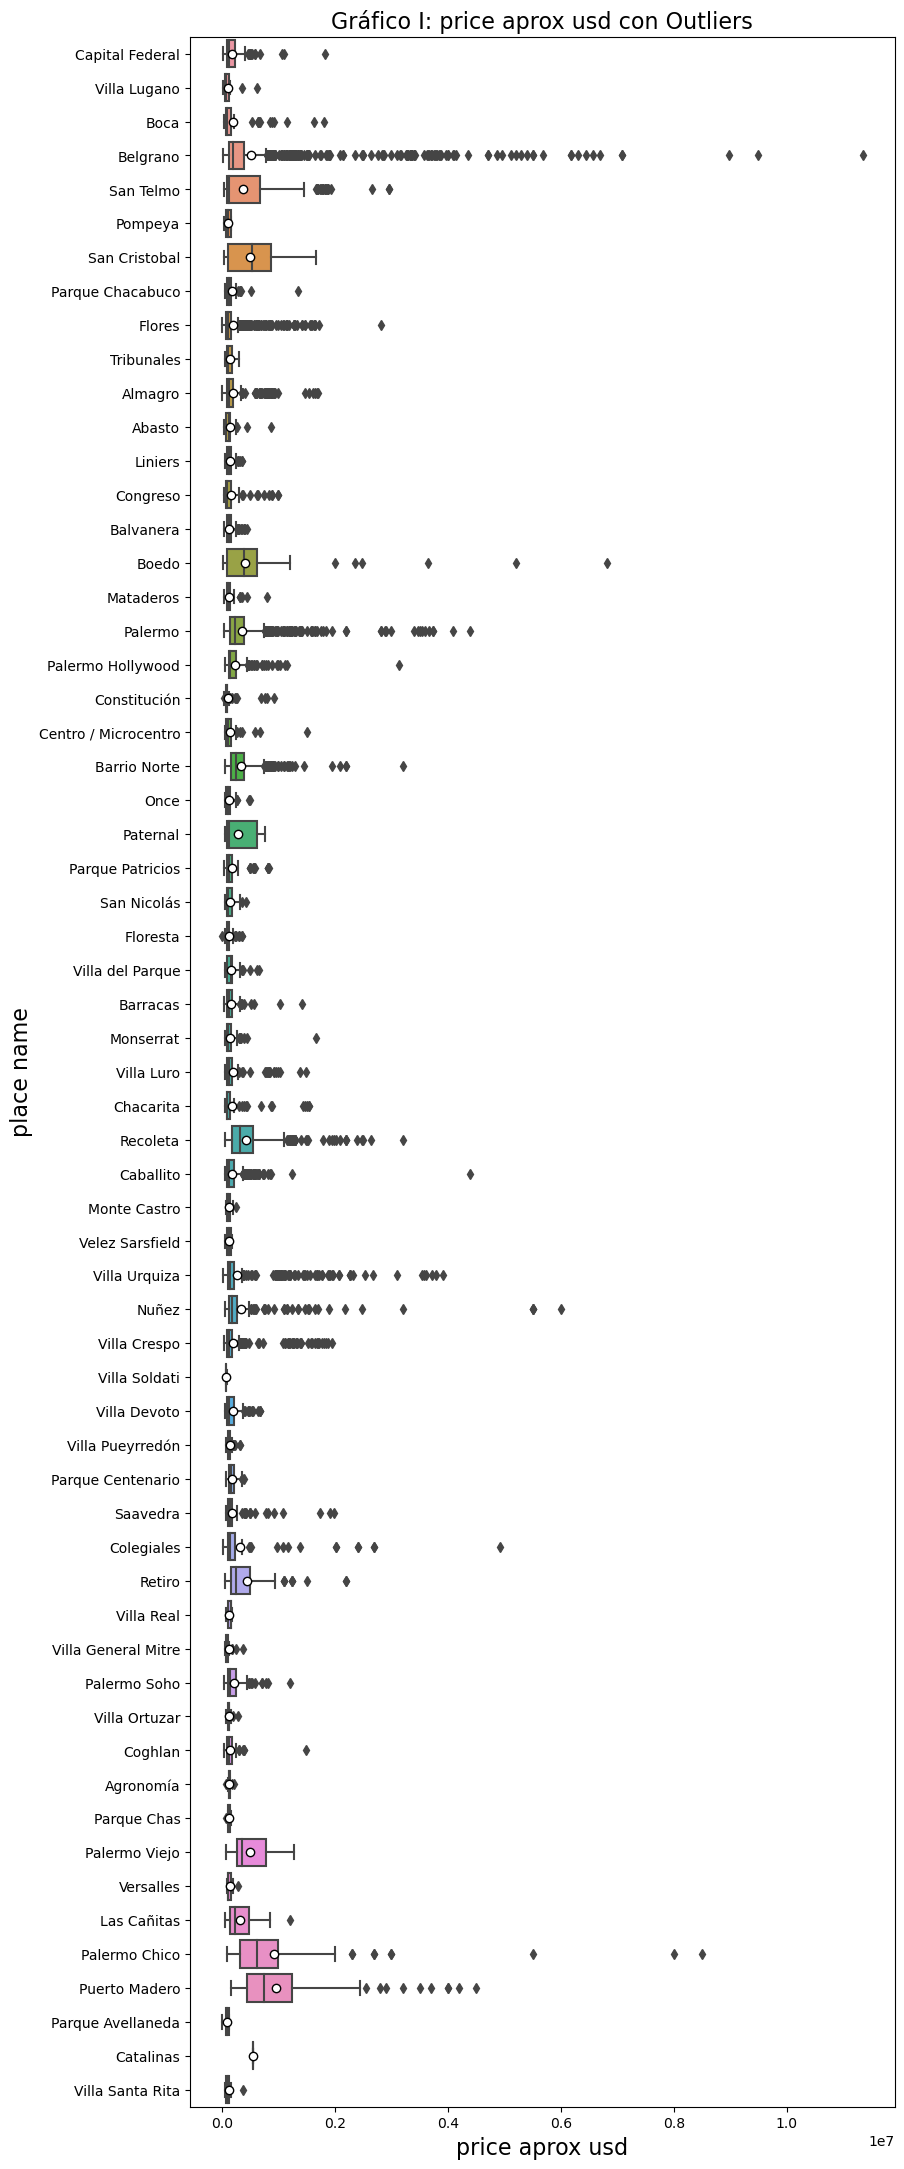

In [24]:
#Boxplot price aprox usd

fig=plt.figure(figsize=(20,30))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data = data, x ='price_aprox_usd' ,y="place_name",showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

ax1.set_title("Gráfico I: price aprox usd con Outliers",fontsize=16)
ax1.set_xlabel('price aprox usd',fontsize=16)
ax1.set_ylabel('place name',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

Al revisar las propiedades por barrio se observa que hay muy pocas por encima de los 800.000 USD y solo se presenta en 2 barrios, por esta razón vamos a dejarlas fuera del analisis.

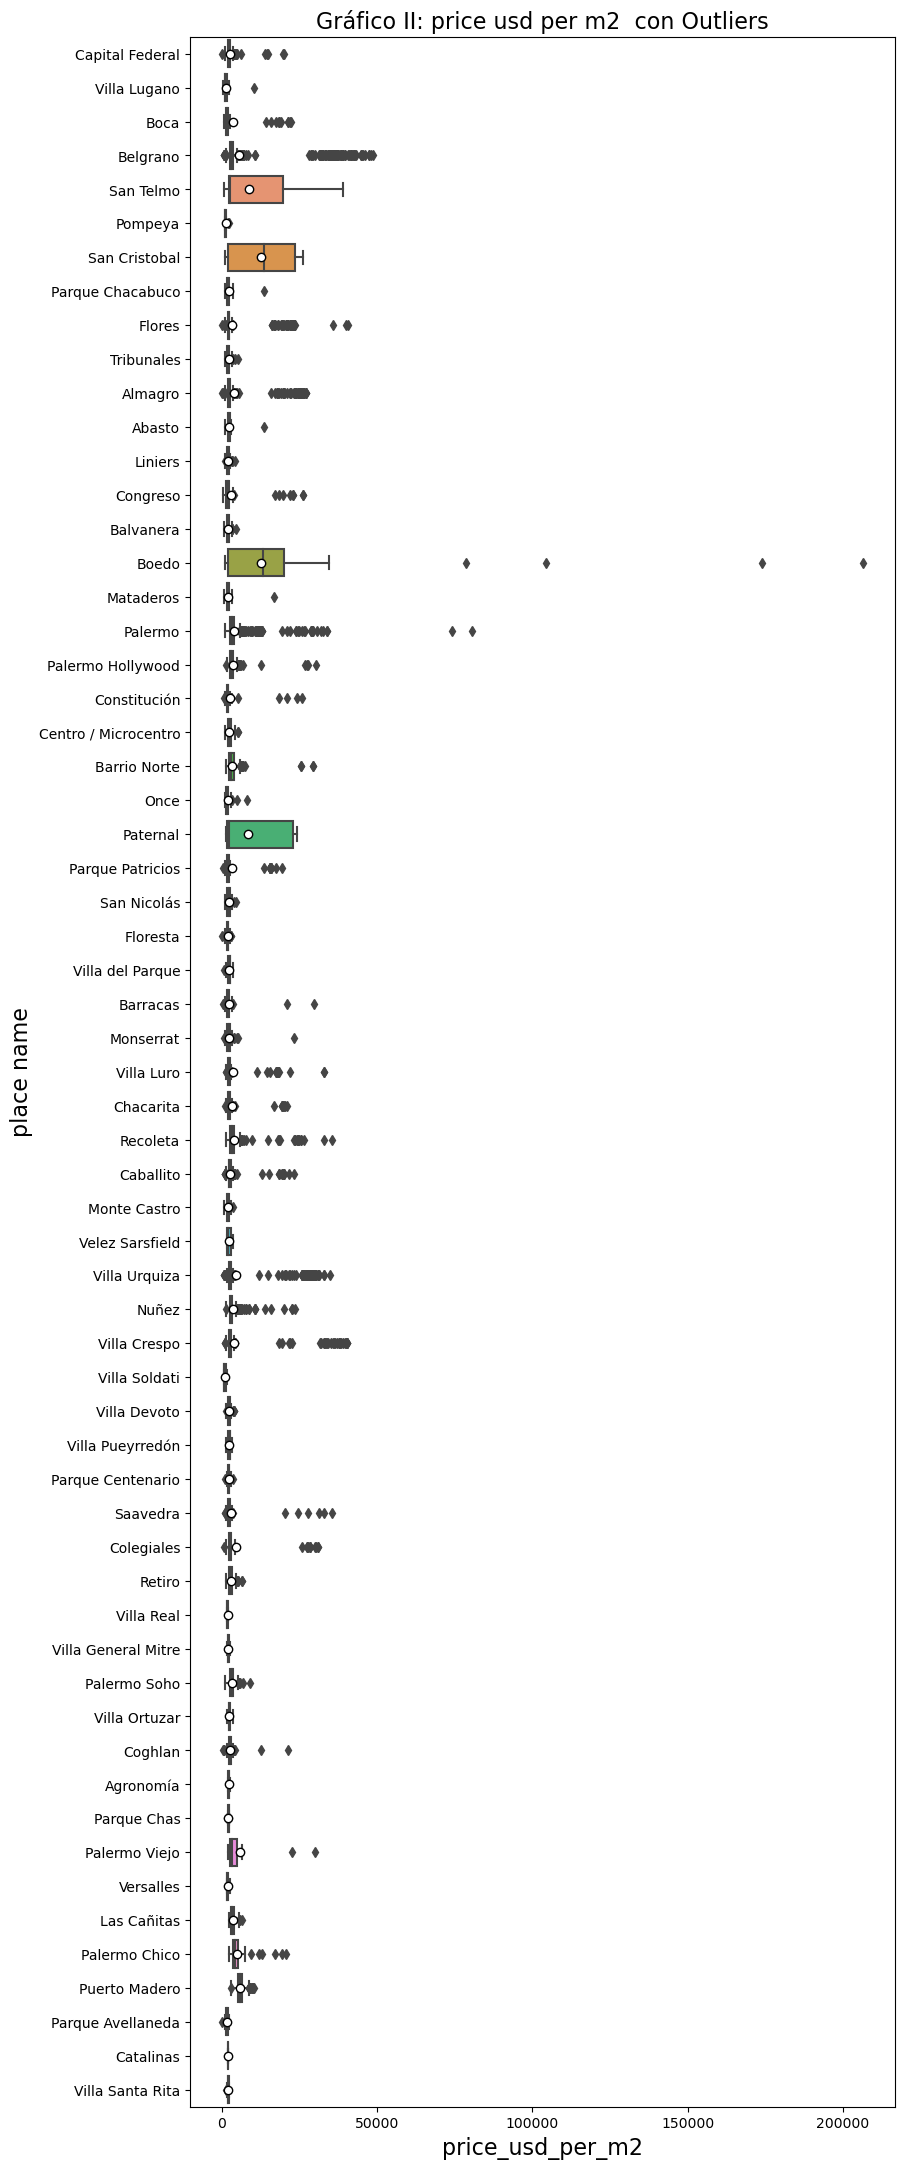

In [25]:
#Boxplot price_usd_per_m2

fig=plt.figure(figsize=(20,30))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data = data, x ='price_usd_per_m2' ,y="place_name",showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

ax1.set_title("Gráfico II: price usd per m2  con Outliers",fontsize=16)
ax1.set_xlabel('price_usd_per_m2',fontsize=16)
ax1.set_ylabel('place name',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

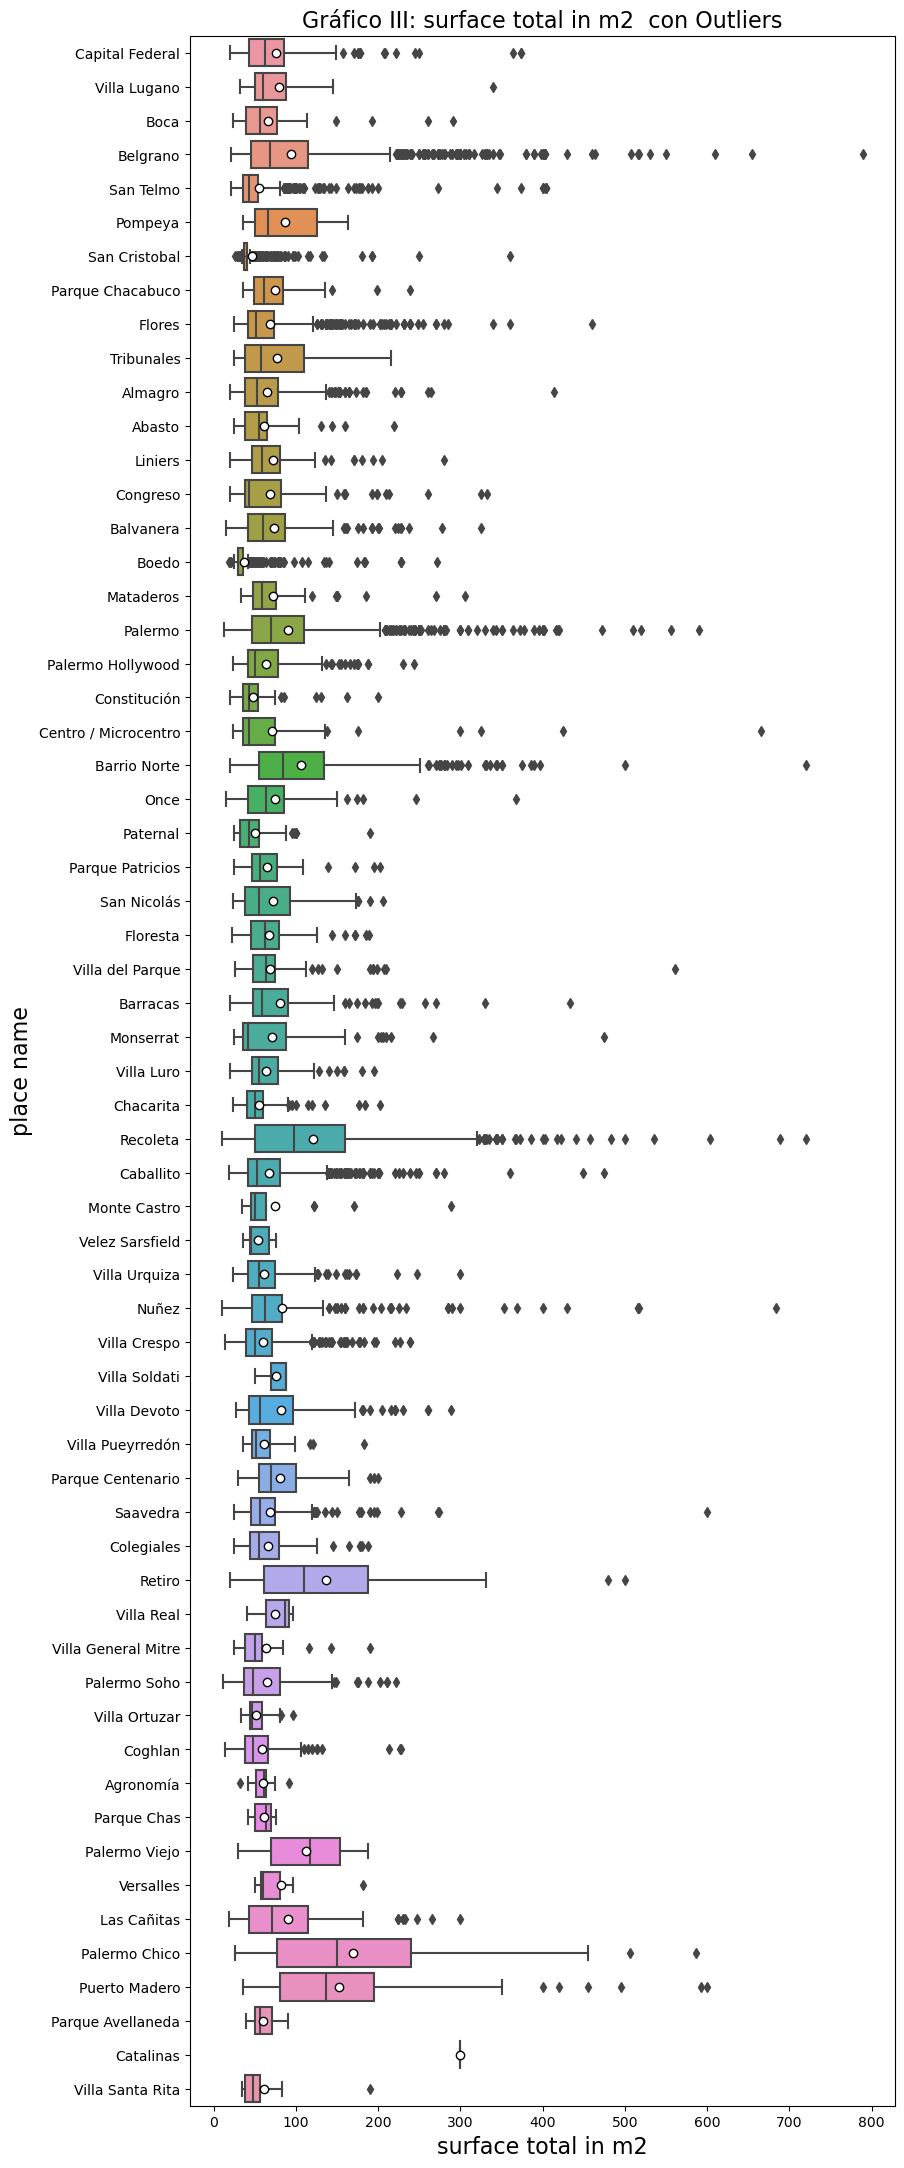

In [26]:
#Boxplot surface total in m2

fig=plt.figure(figsize=(20,30))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data = data, x ='surface_total_in_m2' ,y="place_name",showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

ax1.set_title("Gráfico III: surface total in m2  con Outliers",fontsize=16)
ax1.set_xlabel('surface total in m2',fontsize=16)
ax1.set_ylabel('place name',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

Al revisar las superficies totales en m2 vemos que hay pocos apartamentos con areas totales mayores a 500 m2, los escluiremos del modelo, porque algunos de ellos son edificios.

In [27]:
#Encontramos un dato mal digitado con un valor muy alto, por esta razón lo eliminamos
data=data[(data.surface_covered_in_m2<800)]
data.shape

(14220, 12)

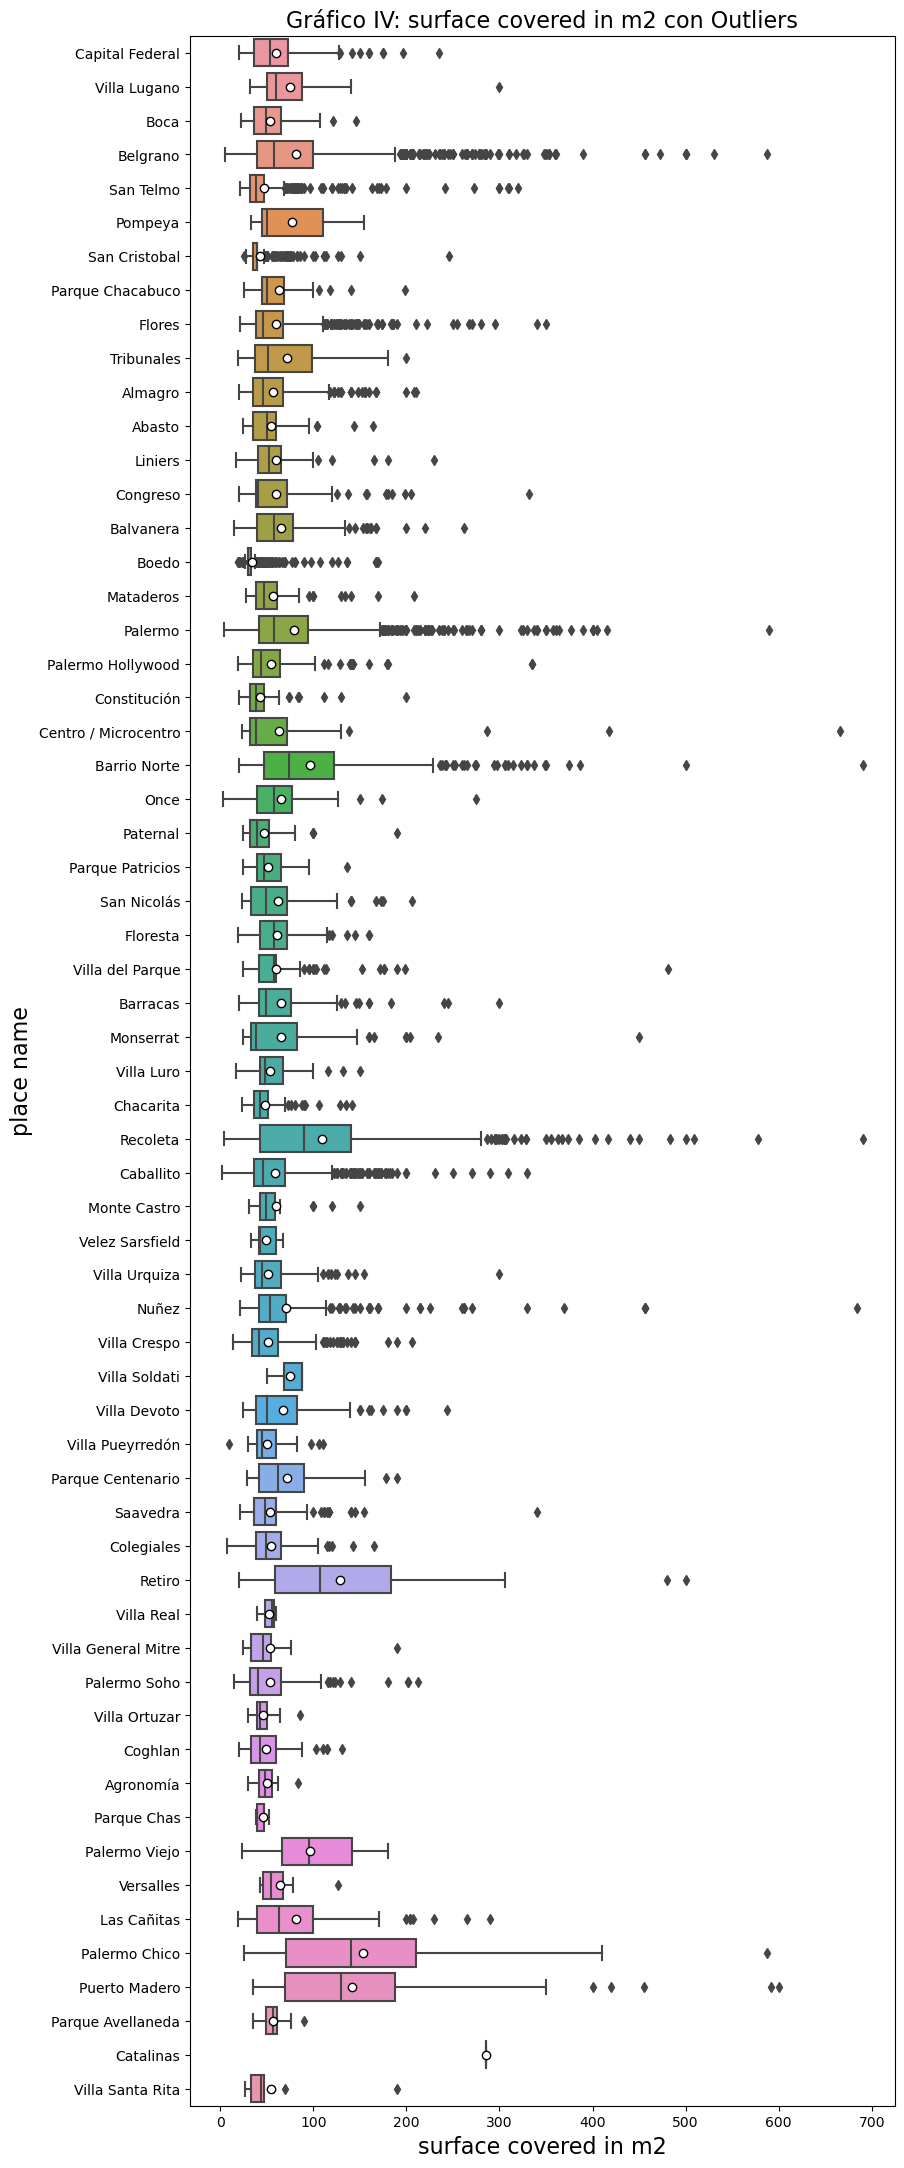

In [28]:
#Boxplot surface covered in m2


fig=plt.figure(figsize=(20,30))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data = data, x ='surface_covered_in_m2' ,y="place_name",showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

ax1.set_title("Gráfico IV: surface covered in m2 con Outliers",fontsize=16)
ax1.set_xlabel('surface covered in m2',fontsize=16)
ax1.set_ylabel('place name',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

Para surface covered in m2 trabajaremos tambien con propiedades con más de 500 m2.

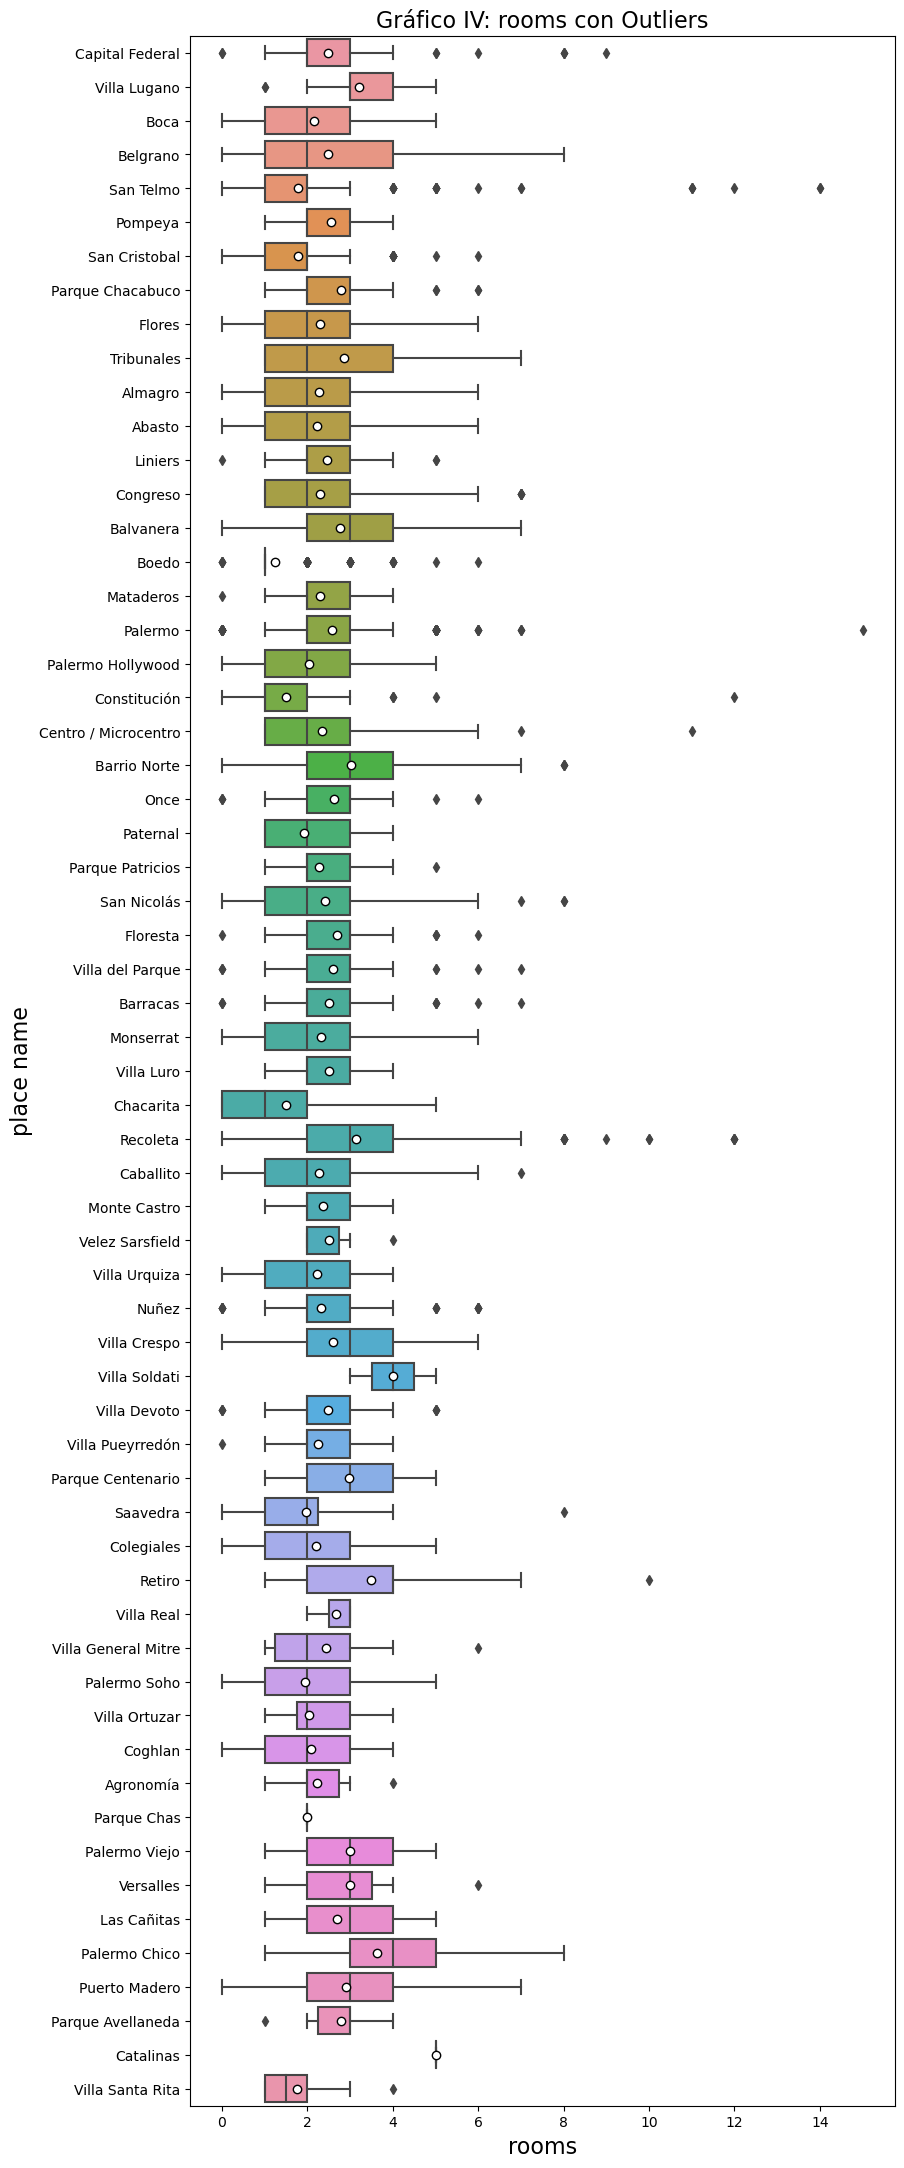

In [13]:
#Boxplot rooms


fig=plt.figure(figsize=(20,30))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data = data, x ='rooms' ,y="place_name",showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

ax1.set_title("Gráfico IV: rooms con Outliers",fontsize=16)
ax1.set_xlabel('rooms',fontsize=16)
ax1.set_ylabel('place name',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

Vamos a trabajar con apartamentos de maximo 7 habitaciones.

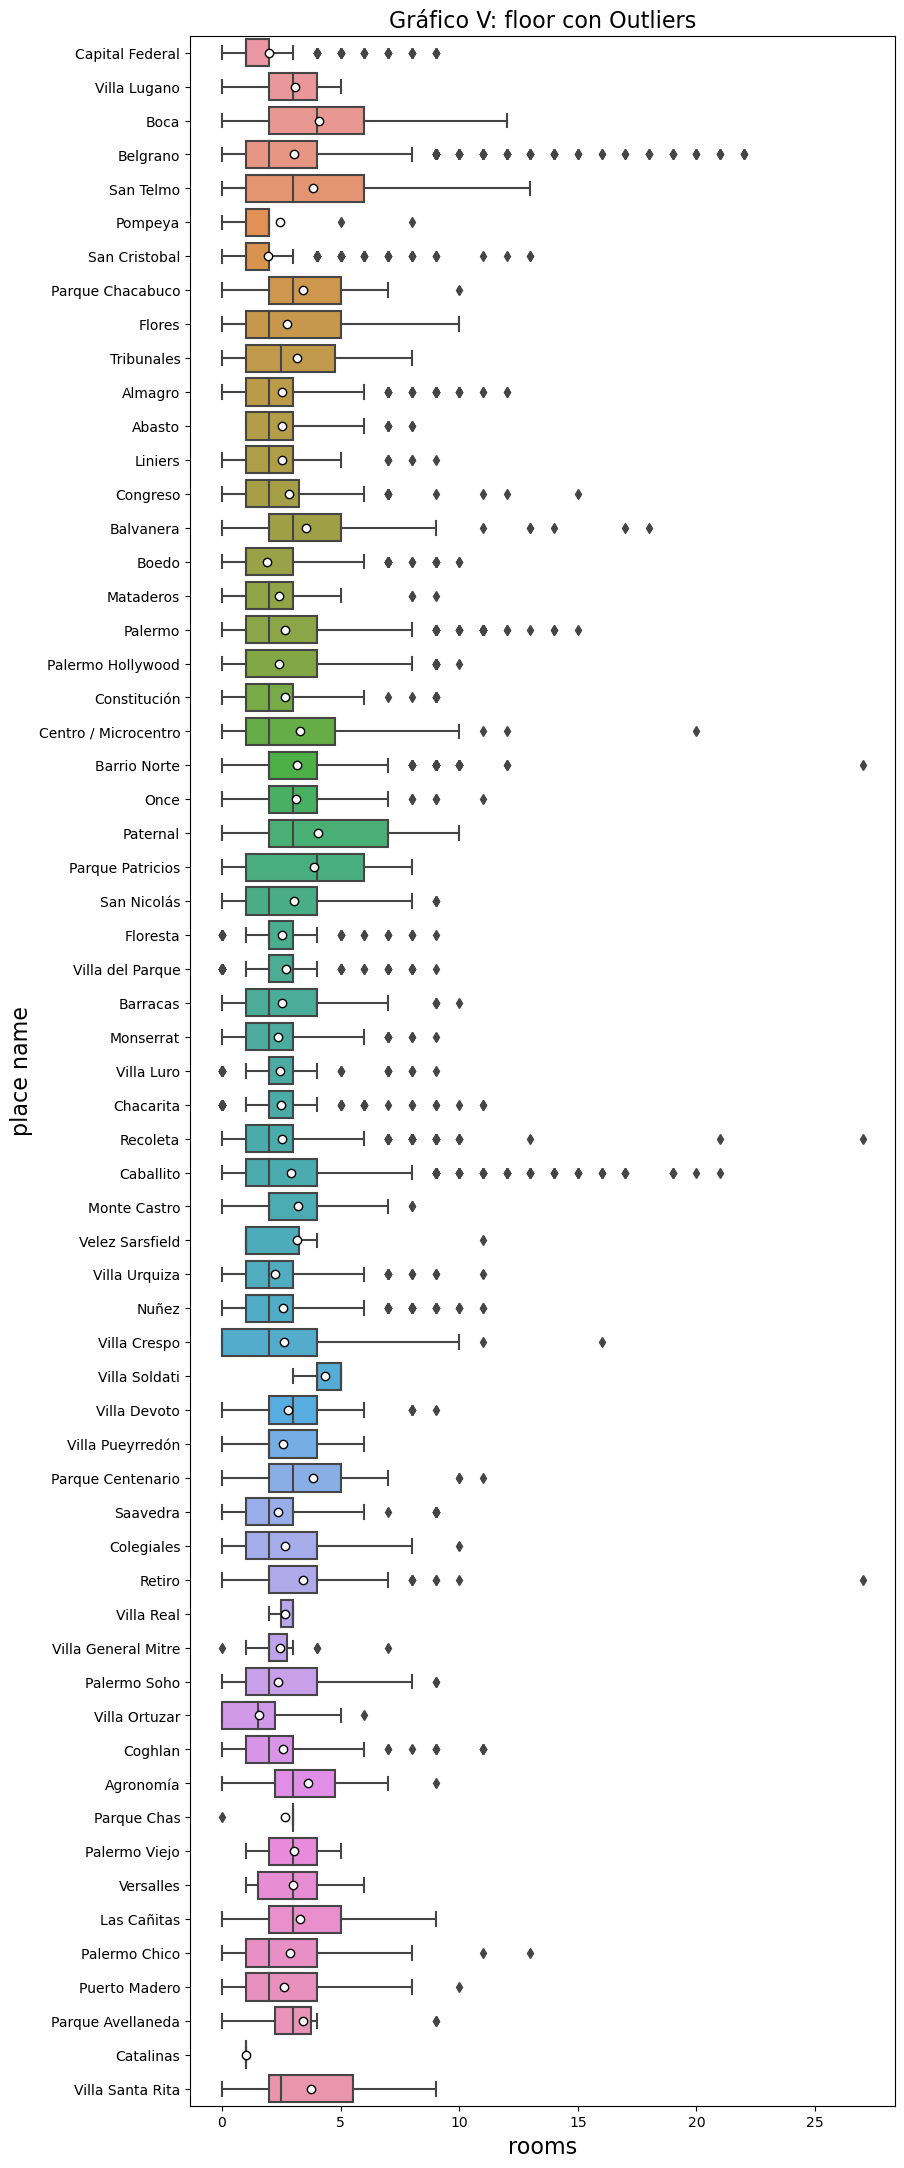

In [14]:
#Boxplot floor

fig=plt.figure(figsize=(20,30))
ax1=fig.add_subplot(1,2,1)
sns.boxplot(data = data, x ='floor' ,y="place_name",showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

ax1.set_title("Gráfico V: floor con Outliers",fontsize=16)
ax1.set_xlabel('rooms',fontsize=16)
ax1.set_ylabel('place name',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

Vamos a trabajar con rooms ubicados por debajo del piso 25

In [15]:
#Vamos a limpiar la base con los criterios definidos para las columnas, por ahora no tomaresmos floor ni rooms porque en gran parte de las propiedades nuevas no están definidos esos valores

data=data[(data.price_aprox_usd<800000) & (data.surface_total_in_m2<500) & (data.surface_covered_in_m2<500)]
data.shape

(13096, 12)

Una vez tenemos una base limpia, sacamos una matriz de correlación para observar el comportamiento entre variables

In [14]:
data.corr()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
price_aprox_usd,1.000000,0.551307,0.571443,0.629622,0.001951,0.359213,-0.000356,0.095047,0.099906,0.153423,-0.054925
surface_total_in_m2,0.551307,1.000000,0.932390,-0.175373,0.113487,0.698607,0.000101,-0.061917,-0.067313,0.135639,-0.300907
surface_covered_in_m2,0.571443,0.932390,1.000000,-0.144268,0.117868,0.738950,0.000760,-0.079152,-0.118795,0.130419,-0.337092
price_usd_per_m2,0.629622,-0.175373,-0.144268,1.000000,-0.092395,-0.192765,-0.001662,0.084792,0.212687,-0.030335,0.199841
floor,0.001951,0.113487,0.117868,-0.092395,1.000000,0.134253,-0.001552,-0.005656,-0.009717,0.074760,-0.205149
rooms,0.359213,0.698607,0.738950,-0.192765,0.134253,1.000000,0.001591,-0.132123,-0.187993,0.082506,-0.425508
expenses,-0.000356,0.000101,0.000760,-0.001662,-0.001552,0.001591,1.000000,-0.008894,-0.010227,-0.008322,0.007977
piscina,0.095047,-0.061917,-0.079152,0.084792,-0.005656,-0.132123,-0.008894,1.000000,0.396353,0.191146,0.235481
Parrilla,0.099906,-0.067313,-0.118795,0.212687,-0.009717,-0.187993,-0.010227,0.396353,1.000000,0.178526,0.275366
Cochera,0.153423,0.135639,0.130419,-0.030335,0.074760,0.082506,-0.008322,0.191146,0.178526,1.000000,0.098766


Graficamos un mapa de calor para identificar cuales son las variables numericas que se relacionan más con el precio aproximado en dolares
Asi podemos ver que los datos que más se relacionan con esta variable son: Superficie total, superficie cubierta, y rooms, en el caso de expenses tiene una correlacion negativa, lo que indica que expensas más altas afectan el precio de la propiedad a la baja.

Text(0.5, 1.0, 'Heatmap')

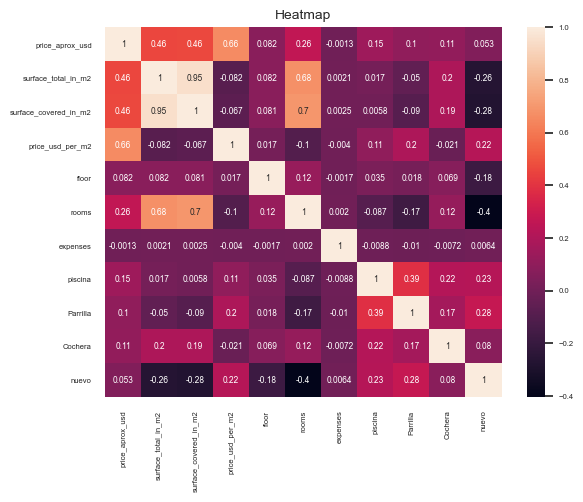

In [29]:
corr=data.corr()
sns.set(font_scale=0.5)
sns.heatmap(corr,annot=True)
plt.title("Heatmap",fontsize=10)

Ahora creamos un grupo de variables categoricas empleando. describe de tipo Object.

In [16]:
cat=data.describe(include=[object])  
cat

,place_name
count,13096
unique,61
top,Belgrano
freq,1251


Calculamos la media de las variables numericas tomando como base las variables **categoricas y las organizamos para poder hacer un analisis general
Lo que podemos ver en este analisis es que  ***por ejemplo que :xxx**

In [17]:
grpmean=data.groupby(list(cat.columns)).mean().sort_values(by=['place_name'])
grpmean[['price_aprox_usd', 'price_usd_per_m2','surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla', 'Cochera', 'nuevo']]

,price_aprox_usd,price_usd_per_m2,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
place_name,,,,,,,,,,,
Abasto,130802.211538,2239.884615,61.288462,54.403846,2.519231,2.230769,5476.923077,0.423077,0.096154,0.057692,0.365385
Agronomía,134777.142857,2288.285714,59.428571,50.500000,3.642857,2.214286,4895.000000,0.642857,0.642857,0.785714,0.714286
Almagro,170218.623870,3265.009042,64.810127,56.878843,2.600362,2.301989,9312.097649,0.126582,0.238698,0.253165,0.361664
Balvanera,133268.857664,1984.171533,72.660584,65.427007,3.558394,2.759124,10329.525547,0.062044,0.098540,0.094891,0.145985
Barracas,148150.220238,1946.017857,80.464286,65.797619,2.500000,2.500000,5326.785714,0.422619,0.232143,0.380952,0.404762
...,...,...,...,...,...,...,...,...,...,...,...
Villa Real,136333.333333,1866.666667,74.000000,52.000000,2.666667,2.666667,10000.000000,0.000000,0.000000,0.000000,0.666667
Villa Santa Rita,124333.333333,2047.833333,61.250000,54.166667,3.750000,1.750000,833.333333,0.166667,0.250000,0.083333,0.583333
Villa Soldati,74666.666667,1096.000000,75.333333,75.333333,4.333333,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Tambien chequeamos cuantos datos tenemos en esa distribución

In [18]:
data.groupby(list(cat.columns)).count()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,nuevo
place_name,,,,,,,,,,,
Abasto,52,52,52,52,52,52,52,52,52,52,52
Agronomía,14,14,14,14,14,14,14,14,14,14,14
Almagro,553,553,553,553,553,553,553,553,553,553,553
Balvanera,274,274,274,274,274,274,274,274,274,274,274
Barracas,168,168,168,168,168,168,168,168,168,168,168
...,...,...,...,...,...,...,...,...,...,...,...
Villa Real,3,3,3,3,3,3,3,3,3,3,3
Villa Santa Rita,12,12,12,12,12,12,12,12,12,12,12
Villa Soldati,3,3,3,3,3,3,3,3,3,3,3


In [19]:
num.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla',
       'Cochera', 'nuevo'],
      dtype='object')

Generamos variables dummies 

In [20]:
datadum=pd.get_dummies(data)
datadum.columns

Index(['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'piscina', 'Parrilla',
       'Cochera', 'nuevo', 'place_name_Abasto', 'place_name_Agronomía',
       'place_name_Almagro', 'place_name_Balvanera', 'place_name_Barracas',
       'place_name_Barrio Norte', 'place_name_Belgrano', 'place_name_Boca',
       'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Catalinas',
       'place_name_Centro / Microcentro', 'place_name_Chacarita',
       'place_name_Coghlan', 'place_name_Colegiales', 'place_name_Congreso',
       'place_name_Constitución', 'place_name_Flores', 'place_name_Floresta',
       'place_name_Las Cañitas', 'place_name_Liniers', 'place_name_Mataderos',
       'place_name_Monserrat', 'place_name_Monte Castro', 'place_name_Nuñez',
       'place_name_Once', 'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Paler

In [21]:
datadum.head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,piscina,Parrilla,Cochera,...,place_name_Villa General Mitre,place_name_Villa Lugano,place_name_Villa Luro,place_name_Villa Ortuzar,place_name_Villa Pueyrredón,place_name_Villa Real,place_name_Villa Santa Rita,place_name_Villa Soldati,place_name_Villa Urquiza,place_name_Villa del Parque
0,16100,115,62,140,2,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,24300,60,60,405,4,4,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19,48000,80,80,600,2,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,29250,39,37,750,2,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
38,38250,51,48,750,2,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Modelo Apartamentos Capital federal

Para el primer modelo emplearemos la base de datos de los apartamentos de capital federal y emplearemos las features surface_total_in_m2, surface_covered_in_m2, rooms,place_name dumisada, para predecir price_aprox_usd

Definimos (X y y) y separamos los datos en test y train y corremos el modelo de regresión con statsmodels

In [22]:
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms','place_name_Abasto', 'place_name_Agronomía',
       'place_name_Almagro', 'place_name_Balvanera', 'place_name_Barracas',
       'place_name_Barrio Norte', 'place_name_Belgrano', 'place_name_Boca',
       'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Catalinas',
       'place_name_Centro / Microcentro', 'place_name_Chacarita',
       'place_name_Coghlan', 'place_name_Colegiales', 'place_name_Congreso',
       'place_name_Constitución', 'place_name_Flores', 'place_name_Floresta',
       'place_name_Las Cañitas', 'place_name_Liniers', 'place_name_Mataderos',
       'place_name_Monserrat', 'place_name_Monte Castro', 'place_name_Nuñez',
       'place_name_Once', 'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Santa Rita', 'place_name_Villa Soldati',
       'place_name_Villa Urquiza', 'place_name_Villa del Parque']
X=datadum[featcol]
y=datadum[['price_aprox_usd']]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=123)

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(9822, 64) (9822, 1)
(3274, 64) (3274, 1)


In [23]:
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms','place_name_Abasto', 'place_name_Agronomía',
       'place_name_Almagro', 'place_name_Balvanera', 'place_name_Barracas',
       'place_name_Barrio Norte', 'place_name_Belgrano', 'place_name_Boca',
       'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Catalinas',
       'place_name_Centro / Microcentro', 'place_name_Chacarita',
       'place_name_Coghlan', 'place_name_Colegiales', 'place_name_Congreso',
       'place_name_Constitución', 'place_name_Flores', 'place_name_Floresta',
       'place_name_Las Cañitas', 'place_name_Liniers', 'place_name_Mataderos',
       'place_name_Monserrat', 'place_name_Monte Castro', 'place_name_Nuñez',
       'place_name_Once', 'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Santa Rita', 'place_name_Villa Soldati',
       'place_name_Villa Urquiza', 'place_name_Villa del Parque']
X=Xtrain[featcol]
y=ytrain

X = sm.add_constant(X)

model_1= sm.OLS(y, X).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     150.6
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        12:34:31   Log-Likelihood:            -1.2816e+05
No. Observations:                9822   AIC:                         2.564e+05
Df Residuals:                    9758   BIC:                         2.569e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Al revisar los resultados podemos concluir lo siguiente:
R2 Y R2 AJUSTADO: presentan unos porcentajes muy bajos del 49.3% y 49.0%, lo que señala que el modelo no predice el valor de las propiedades al emplear estas variables.
Por otra parte vemos unos pvalues por encima del 0.05, lo que nos indica que no serian features que ayuden con la predicción del modelo.

Ahora vamos a correr el modelo con sklearn, para lo cual mantenemos las mismas feaatures para predecir el precio de la propiedad en dolares.

In [24]:
featcol=['surface_total_in_m2', 'surface_covered_in_m2', 'rooms','place_name_Abasto', 'place_name_Agronomía',
       'place_name_Almagro', 'place_name_Balvanera', 'place_name_Barracas',
       'place_name_Barrio Norte', 'place_name_Belgrano', 'place_name_Boca',
       'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Catalinas',
       'place_name_Centro / Microcentro', 'place_name_Chacarita',
       'place_name_Coghlan', 'place_name_Colegiales', 'place_name_Congreso',
       'place_name_Constitución', 'place_name_Flores', 'place_name_Floresta',
       'place_name_Las Cañitas', 'place_name_Liniers', 'place_name_Mataderos',
       'place_name_Monserrat', 'place_name_Monte Castro', 'place_name_Nuñez',
       'place_name_Once', 'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Santa Rita', 'place_name_Villa Soldati',
       'place_name_Villa Urquiza', 'place_name_Villa del Parque']


Xtrain_sklearn = Xtrain[featcol]

model_1 = LinearRegression(fit_intercept=True)

model_1.fit(Xtrain_sklearn, ytrain)

print(model_1.coef_)

print(model_1.intercept_)

[[ 7.75404259e+02  1.61458273e+03 -3.78722352e+03 -2.39564263e+04
  -1.56472211e+04  8.97459311e+03 -5.00728849e+04 -3.78941556e+04
   4.48233085e+04  4.39426402e+04 -3.23943142e+04  2.33143054e+05
  -1.16733922e+03 -1.24762983e+04 -1.54455064e+05 -2.46666065e+04
  -1.75797573e+04 -5.93011321e+03  2.02897808e+03 -4.63399481e+04
  -3.24882424e+04 -2.01875782e+04 -4.76854115e+04  8.19934353e+04
  -3.63492745e+04 -4.52648151e+04 -5.13647275e+04 -6.09786344e+04
   3.18777662e+04 -5.43738529e+04  7.01388149e+04  1.54084131e+05
   3.82643583e+04  4.55809033e+04  9.41037701e+04 -5.95754334e+04
  -1.77760452e+04 -2.59777814e+04 -1.46973605e+04 -1.20793301e+04
   1.83148943e+05 -1.15457231e+05  2.28960333e+05  8.44499450e+04
   2.46814266e+04 -2.49384146e+03  1.26274860e+05 -2.82945250e+04
   7.22860748e+04 -5.98683978e+04 -1.35465060e+04 -4.30886934e+04
  -4.69830424e+03 -3.31749182e+03 -3.38474753e+04 -9.86340581e+04
  -1.30429362e+04 -1.02708887e+04 -1.47546460e+04 -2.55194470e+04
  -3.70298

In [25]:
print("R2: ", model_1.score(Xtrain_sklearn, ytrain))

n = len(ytrain)
p = 5
ypred_train = model_1.predict(Xtrain_sklearn)
r2 = metrics.r2_score(ytrain, ypred_train)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

print("R2: ", metrics.r2_score(ytrain, ypred_train))
print("R2 ajustado: ", r2_ajustado)
print('Mean Absolute Error:', metrics.mean_absolute_error(ytrain, ypred_train))
print('Mean Squared Error:', metrics.mean_squared_error(ytrain, ypred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytrain, ypred_train)))

R2:  0.4930584403814401
R2:  0.4930584403814401
R2 ajustado:  0.4928002183156197
Mean Absolute Error: 64311.14975294392
Mean Squared Error: 12616597044.057705
Root Mean Squared Error: 112323.62638402352


Al revisar los datos obtenidos del modelo para los datos de train, se observa un R2 de 0.493 y un R2 ajustado de 0.492 lo que señala que el modelo no se ajusta los suficiente a la predicción del precio de la propiedad.

In [26]:
Xtest_sklearn = Xtest[featcol]

print("R2: ", model_1.score(Xtest_sklearn, ytest))

n = len(ytest)
p = 5
ypred_test = model_1.predict(Xtest_sklearn)
r2 = metrics.r2_score(ytest, ypred_test)
r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))

print("R2: ", metrics.r2_score(ytest, ypred_test))
print("R2 ajustado: ", r2_ajustado)
print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, ypred_test))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, ypred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred_test)))

R2:  0.5308764427281429
R2:  0.5308764427281429
R2 ajustado:  0.5301586894275434
Mean Absolute Error: 62165.430317682505
Mean Squared Error: 11458303244.232285
Root Mean Squared Error: 107043.46427611676


Al revisar los datos obtenidos del modelo para los datos de test, se observa un R2 de 0.5308 y un R2 ajustado de 0.5301 lo que señala que el modelo no se ajusta los suficiente a la predicción del precio de la propiedad.